<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_5.ipynb)

#Target:
1. Add **Learning Rate Scheduler**
2. Maintain Consistent Test Accuracy

#Results:
1. Parameters: `9,866`
2. Best Training Accuracy: `99.27%` 
3. Best Test Accuracy: `99.55%`
4. Epochs: 15

# Analysis: (`Net` without dropout)
1. Using LR scheduler, can maintain somewhat consistent accuracy `99.5x%` 
2. Train Accuracy is increasing for each epoch
3. Seeing bit of underfitting(Train: `99.27%`, Test: `99.54%`)
4. Achieved required Test Accuracy 

- - -

#Results:
1. Parameters: `9,866`
2. Best Training Accuracy: `99.02%` 
3. Best Test Accuracy: `99.47%`
4. Epochs: 15

# Analysis: (`Net2` with 0.1 dropout)
1. Using Augmentation we can achieve `99.47%` accuracy
2. Train Accuracy is increasing for each epoch
3. Test Accuracy is increasing stable (No DOWN in accuracy)
4. Seeing bit of underfitting(Train: `99.01%`, Test: `99.47%`)
5. Achieved required Test Accuracy 

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

Applying following three transformation

1.   Compose - group multiple transform into sequential transform
2.   ToTensor - Convert numpy | PILImage to tensor and convert range between 0-1 
`(i.e) array/255`
3. Normalize - input data(train & test) is normalized besed on `mean` & `std` 
`(i.e) (i'th value - mean)/std => final i'th range becomes (-1, 1)`
4. Slight RandomRotate (right to left rotate)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 20), fill=(1, )),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 6

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Training and Testing

In [0]:
def train(model, device, train_loader, optimizer, epoch, train_repo):
  train_losses, train_acc = train_repo
  model.train()
  pbar = tqdm(iterable=train_loader, total=len(train_loader), position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_repo):
    test_losses, test_acc = test_repo
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Draw Accuracy Graph

In [0]:
def draw_accuracy(train_repo, test_repo):
  train_losses, train_acc = train_repo
  test_losses, test_acc = test_repo
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

# Training Model (1)

In [0]:
class Net(nn.Module):
    def __init__(self, fm_size):
        super(Net, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.2), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.2)),
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.2)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.2), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.2)),
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.2)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
        ) # output_size = 7

        self.avg = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = Net(14).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
            Conv2d-4           [-1, 14, 24, 24]           1,764
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7           [-1, 16, 22, 22]           2,016
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 13, 11, 11]             208
             ReLU-12           [-1, 13, 11, 11]               0
      BatchNorm2d-13           [-1, 13, 11, 11]              26
           Conv2

### Train and test our model with `LR Scheduler`
* As we see Test Accuracy is fluctuating from 5th epoch onwards.
* If I add `step_size=5`, can't achieve 99.4 accuracy its end with 99.3
* So I have Added `StepLR` with `step_size=10` to maintain consistent Test Accuracy (Its working fine)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1, *Applied LR: [0.01]


Loss=0.12822522222995758 Batch_id=468 Accuracy=87.33: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9817/10000 (98.17%)

EPOCH: 2, *Applied LR: [0.01]


Loss=0.08301996439695358 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:12<00:00, 36.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9868/10000 (98.68%)

EPOCH: 3, *Applied LR: [0.01]


Loss=0.08777448534965515 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9894/10000 (98.94%)

EPOCH: 4, *Applied LR: [0.01]


Loss=0.06392156332731247 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9904/10000 (99.04%)

EPOCH: 5, *Applied LR: [0.01]


Loss=0.07804300636053085 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9899/10000 (98.99%)

EPOCH: 6, *Applied LR: [0.01]


Loss=0.03638974204659462 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 36.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9916/10000 (99.16%)

EPOCH: 7, *Applied LR: [0.01]


Loss=0.0471368245780468 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 37.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99.19%)

EPOCH: 8, *Applied LR: [0.01]


Loss=0.02124348282814026 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 36.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 9, *Applied LR: [0.01]


Loss=0.07008689641952515 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9905/10000 (99.05%)

EPOCH: 10, *Applied LR: [0.01]


Loss=0.0335441529750824 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9919/10000 (99.19%)

EPOCH: 11, *Applied LR: [0.00015129]


Loss=0.007281308528035879 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9951/10000 (99.51%)

EPOCH: 12, *Applied LR: [0.00123]


Loss=0.055928077548742294 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 36.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9950/10000 (99.50%)

EPOCH: 13, *Applied LR: [0.00123]


Loss=0.029625704512000084 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9955/10000 (99.55%)

EPOCH: 14, *Applied LR: [0.00123]


Loss=0.014029085636138916 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9951/10000 (99.51%)

EPOCH: 15, *Applied LR: [0.00123]


Loss=0.030467674136161804 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]



Test set: Average loss: 0.0180, Accuracy: 9954/10000 (99.54%)

---------------------------------------------------------------------------


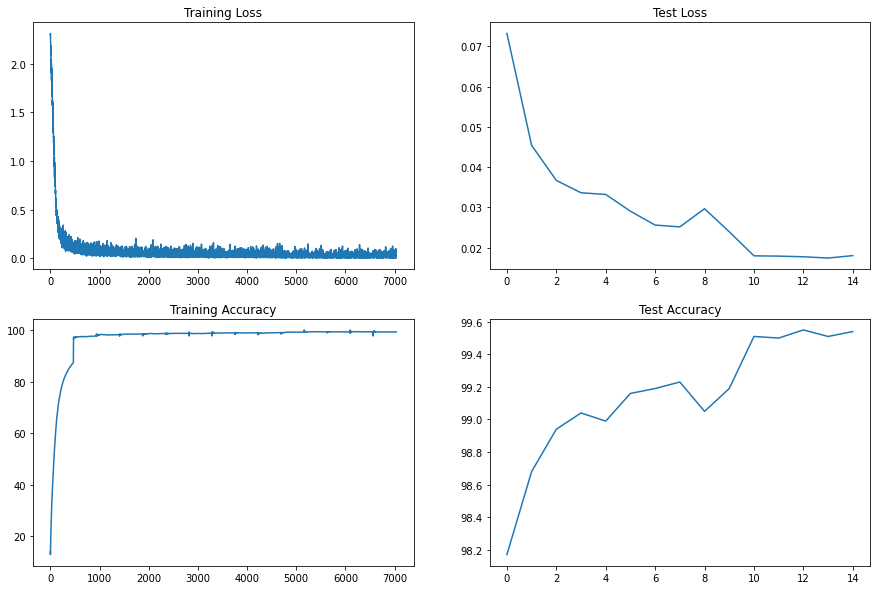

In [18]:
model =  Net(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.123)
# scheduler = MultiStepLR(optimizer=optimizer, milestones=[5, 8, 11, ], gamma=0.12)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print(f"EPOCH: {epoch}, *Applied LR: {scheduler.get_lr()}")
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)
    scheduler.step()

print("-"*75)
draw_accuracy(train_repo, test_repo)

### (Test) Running Model to see, `where to apply LR Scheduler`
* Test Accuracy is fluctuating after 5th epoch onwards

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.08314687758684158 Batch_id=468 Accuracy=87.38: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0782, Accuracy: 9800/10000 (98.00%)

EPOCH: 2


Loss=0.030632352456450462 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9839/10000 (98.39%)

EPOCH: 3


Loss=0.06929370760917664 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.02587621845304966 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.02029384672641754 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.03169381991028786 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.080233633518219 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.011884793639183044 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.007819239981472492 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.1149950698018074 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.042162925004959106 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.010845060460269451 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.01247608195990324 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.0241975337266922 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 15


Loss=0.01591089367866516 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.88it/s]



Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

---------------------------------------------------------------------------


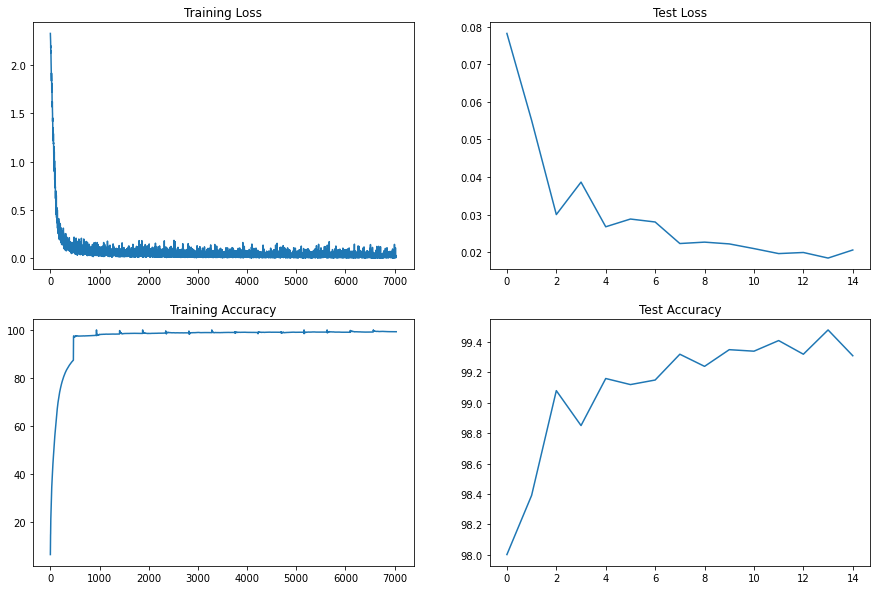

In [9]:
model =  Net(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("-"*75)
draw_accuracy(train_repo, test_repo)

# Training Model (2)

In [0]:
class Net2(nn.Module):
    def __init__(self, fm_size, dropout_value=0.25):
        super(Net2, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        self.dropout_value = dropout_value
        self.dropout = nn.Dropout2d(self.dropout_value)
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.2), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.2)),
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.2)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.2), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.2)),
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.2)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
        ) # output_size = 7

        self.avg = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        # x = self.dropout(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = Net2(14, 0.1).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
            Conv2d-4           [-1, 14, 24, 24]           1,764
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7           [-1, 16, 22, 22]           2,016
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        Dropout2d-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12           [-1, 13, 11, 11]             208
             ReLU-13           [-1, 13, 11, 11]               0
      BatchNorm2

### Train and test our model (Net2 - has 0.1 dropout)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1, *Applied LR: [0.01]


Loss=0.09803685545921326 Batch_id=468 Accuracy=86.56: 100%|██████████| 469/469 [00:12<00:00, 37.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0860, Accuracy: 9773/10000 (97.73%)

EPOCH: 2, *Applied LR: [0.01]


Loss=0.04156045243144035 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9872/10000 (98.72%)

EPOCH: 3, *Applied LR: [0.01]


Loss=0.07141498476266861 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:12<00:00, 36.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9885/10000 (98.85%)

EPOCH: 4, *Applied LR: [0.01]


Loss=0.01928718388080597 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:12<00:00, 37.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9902/10000 (99.02%)

EPOCH: 5, *Applied LR: [0.01]


Loss=0.0700453594326973 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:11<00:00, 39.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9906/10000 (99.06%)

EPOCH: 6, *Applied LR: [0.01]


Loss=0.06383900344371796 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:12<00:00, 37.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 7, *Applied LR: [0.01]


Loss=0.036655113101005554 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 36.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9909/10000 (99.09%)

EPOCH: 8, *Applied LR: [0.01]


Loss=0.02371308207511902 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:12<00:00, 37.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 9, *Applied LR: [0.01]


Loss=0.04952578619122505 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)

EPOCH: 10, *Applied LR: [0.01]


Loss=0.02530927024781704 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:12<00:00, 37.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 11, *Applied LR: [0.00015129]


Loss=0.07715575397014618 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 38.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 12, *Applied LR: [0.00123]


Loss=0.019447103142738342 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 37.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9945/10000 (99.45%)

EPOCH: 13, *Applied LR: [0.00123]


Loss=0.01760629378259182 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 14, *Applied LR: [0.00123]


Loss=0.061109233647584915 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 38.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

EPOCH: 15, *Applied LR: [0.00123]


Loss=0.03225013241171837 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 37.39it/s]



Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)

---------------------------------------------------------------------------


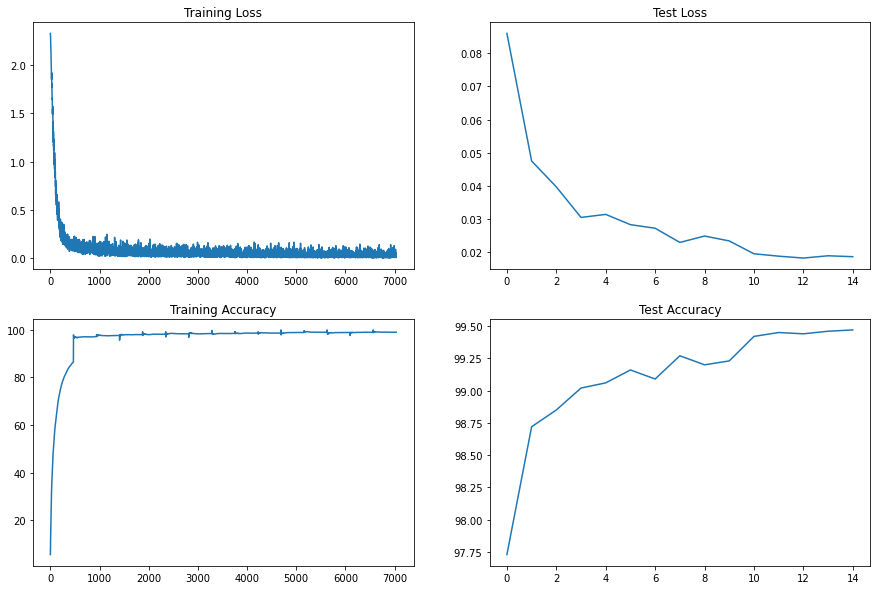

In [20]:
model =  Net2(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.123)
# scheduler = MultiStepLR(optimizer=optimizer, milestones=[5, 8, 11, ], gamma=0.12)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print(f"EPOCH: {epoch}, *Applied LR: {scheduler.get_lr()}")
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)
    scheduler.step()

print("-"*75)
draw_accuracy(train_repo, test_repo)